## Part 1

array([[<Axes: title={'center': 'loc'}>, <Axes: title={'center': 'loc'}>],
       [<Axes: title={'center': 'df'}>, <Axes: title={'center': 'df'}>],
       [<Axes: title={'center': 'scale'}>,
        <Axes: title={'center': 'scale'}>]], dtype=object)

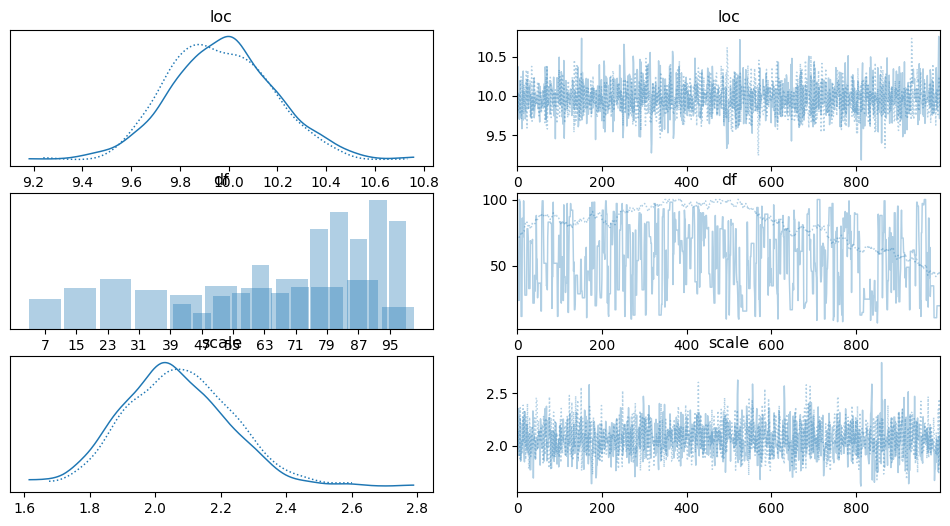

In [ ]:
import pymc as pm
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

n, loc_true, scale_true, df_true = 100, 10, 2, 15
x = stats.t(df = df_true, loc = loc_true, scale = scale_true).rvs(n)

model = pm.Model()
with model:
  loc = pm.Normal("loc", mu=0, sigma=10)
  scale = pm.HalfNormal("scale", sigma=5)
  df = pm.DiscreteUniform("df", lower=1, upper=100)
  x_obs = pm.StudentT("likelihood", mu=loc, sigma=scale, nu=df, observed=x)

with model:
  idata=pm.sample()

import arviz as az
az.plot_trace(idata)

With small n we observe the df to be almost uniform like and it doesn't have solid inclination to where the true population parameter lies.

array([[<Axes: title={'center': 'loc'}>, <Axes: title={'center': 'loc'}>],
       [<Axes: title={'center': 'df'}>, <Axes: title={'center': 'df'}>],
       [<Axes: title={'center': 'scale'}>,
        <Axes: title={'center': 'scale'}>]], dtype=object)

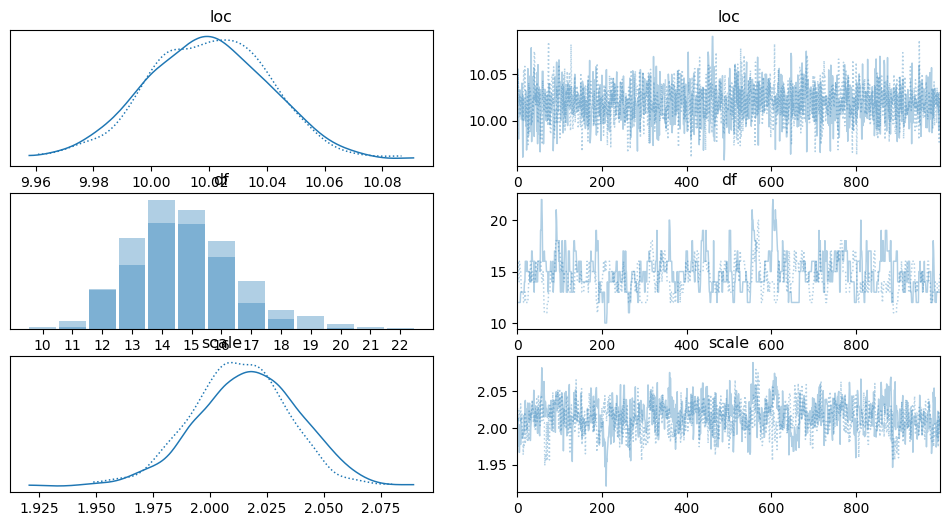

In [ ]:
n_big, loc_true, scale_true, df_true = 10000, 10, 2, 15
x_big = stats.t(df = df_true, loc = loc_true, scale = scale_true).rvs(n_big)

big_model = pm.Model()
with big_model:
  loc = pm.Normal("loc", mu=0, sigma=10)
  scale = pm.HalfNormal("scale", sigma=5)
  df = pm.DiscreteUniform("df", lower=1, upper=100)
  x_obs = pm.StudentT("likelihood", mu=loc, sigma=scale, nu=df, observed=x_big)
  jdata=pm.sample()

import arviz as az
az.plot_trace(jdata)

Increasing n we can see that the df graph has a muich stronger hold on the actual population parameters distribution. As the peaks of the graph seem to be very close to 15. Much better than the small sample size.

## Part 2
Diagnostics for part 1

In [ ]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
loc,9.97,0.21,9.61,10.38,0.00,0.00,2007.48,1253.05,1.00
df,68.15,25.05,20.00,100.00,10.44,8.16,5.64,81.34,1.27
scale,2.07,0.16,1.76,2.34,0.00,0.00,1448.64,1231.99,1.01


In [ ]:
az.summary(jdata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
loc,10.02,0.02,9.98,10.06,0.00,0.00,2144.43,1438.24,1.00
df,14.67,1.72,11.00,17.00,0.12,0.09,198.46,268.49,1.01
scale,2.01,0.02,1.97,2.05,0.00,0.00,346.24,567.75,1.01


We can see that the R-Hat statistic for the small sample size of df is greater than 1 by a lot.

In [ ]:
# small sample
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata).items()}, end=' | ')

print()
# big sample
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(jdata).items()}, end=' | ')

HMC Split-Rhats {'loc': 1.0023, 'df': 1.2711, 'scale': 1.0052} | 
HMC Split-Rhats {'loc': 0.9999, 'df': 1.0142, 'scale': 1.0076} | 

In [ ]:
idata.sample_stats["diverging"].sum()

<xarray.DataArray 'diverging' ()>
array(0)

In [ ]:
jdata.sample_stats["diverging"].sum()

<xarray.DataArray 'diverging' ()>
array(0)

0 divergences in both models

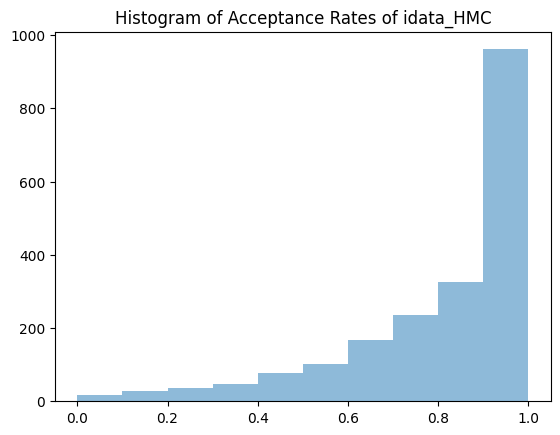

In [ ]:
plt.hist(idata.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,);
plt.title('Histogram of Acceptance Rates of idata_HMC');

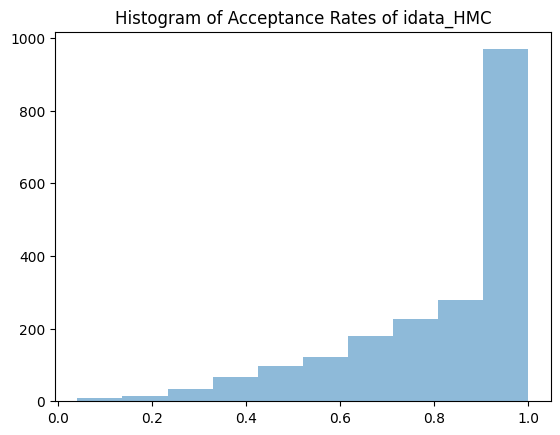

In [ ]:
plt.hist(jdata.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,);
plt.title('Histogram of Acceptance Rates of idata_HMC');

Both show high acceptance rates close to 1

## Part 2
Eight school uncentered vs centered model

In [ ]:
# Eight Schools
import numpy as np
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])


import pymc as pm


with pm.Model() as Centered_eight:

    # We assume the following prior distributions for our parameters
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)

    # and we assume the following probabilistic hierarchy
    # within the data generating mechanism
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J) # theta is length J=8

    # Note that if tau was small, then the density evalution above
    # could change rapidly for changes in theta
    # This means that the energy has high curvature

    # likelihood where observed information enters into the model
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

In [ ]:
# This posterior distribution implied by this specification can be sampled from
# using HMC where the necessary auxiliary variables are added "under the hood"
SEED = [20100420, 20134234] # random seeds for each of two run HMC chains
with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

In [ ]:
# As is seen above, there are many divergences because the specification above
# induces high curature in the energy, but the following alternative
# parameterization alleviates this problem.

with pm.Model() as NonCentered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    # Changes in theta now take place on a fixed scale that is independent of tau

    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    # Changes in tau can still result in rapid changes in the density evaluations
    # below so the energy still has high curvature with respect to tau; but,
    # it no longer has high curvature with respect to theta
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)


with NonCentered_eight:
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True})
# Now very few divergences... problem solved!

In [ ]:

import pandas as pd
print("Effective Sample Sizes (function of Markov Chain autocorrelation dependency)")
pd.concat(
[pd.DataFrame({'Centered': pm.summary(fit_C)[:1]['ess_bulk'],
              'Non-Centered': pm.summary(fit_NC)['ess_bulk'][:1]}),
 pd.DataFrame({'Centered': pm.summary(fit_C)[1:]['ess_bulk'],
              'Non-Centered': pm.summary(fit_NC)['ess_bulk'][9:]})])

Effective Sample Sizes (function of Markov Chain autocorrelation dependency)


,Centered,Non-Centered
mu,623.0,11120.0
tau,129.0,5121.0
theta[0],538.0,10859.0
theta[1],978.0,11965.0
theta[2],1575.0,11071.0
theta[3],965.0,12523.0
theta[4],1673.0,11294.0
theta[5],1769.0,10616.0
theta[6],415.0,11073.0
theta[7],1248.0,11415.0


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>]],
      dtype=object)

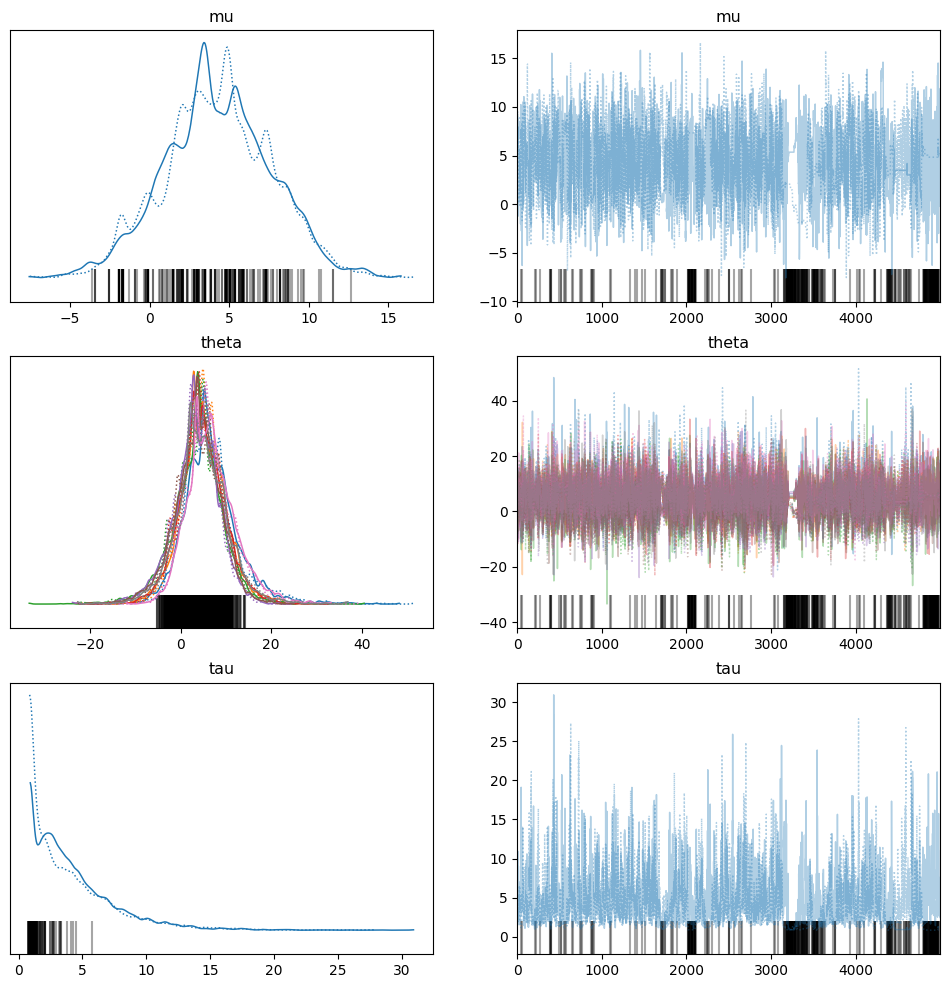

In [ ]:
# Convergence plots for Centered data
fig,ax = plt.subplots(3,2, figsize=(12,12))
az.plot_trace(fit_C, axes=ax[:3,:2])

In [ ]:
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(fit_C).items()}, end=' | ')

HMC Split-Rhats {'mu': 1.0055, 'theta': array([1.0065, 1.0039, 1.0032, 1.0046, 1.0017, 1.0035, 1.006 , 1.0024]), 'tau': 1.0226} | 

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'theta_t'}>,
        <Axes: title={'center': 'theta_t'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

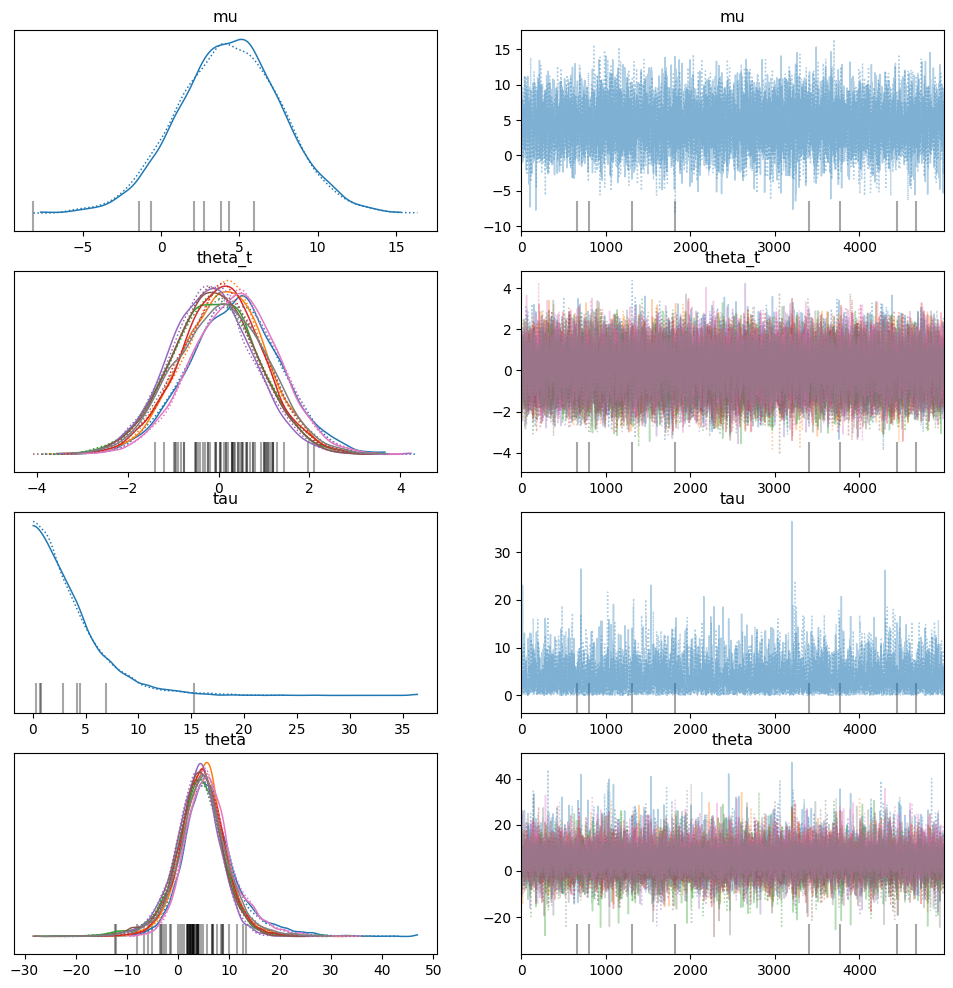

In [ ]:
# Convergence plot for uncentred data
fig,ax = plt.subplots(4,2, figsize=(12,12))
az.plot_trace(fit_NC, axes=ax[:4,:2])

In [ ]:
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(fit_NC).items()}, end=' | ')

HMC Split-Rhats {'mu': 1.0001, 'theta_t': array([1.0001, 1.0002, 1.    , 0.9999, 1.0002, 1.    , 1.0001, 1.0016]), 'tau': 1.0001, 'theta': array([1.0002, 1.0002, 1.    , 1.0006, 1.0007, 0.9999, 0.9999, 1.    ])} | 

We can see from the convergence plots that the distributions being formed by the uncentred data resemble a normal distribution, however for the centered model we can see the distribution is all over the place and does not represent a normal distribution.

From the R-Hat statistic we can see that for the noncentred distribution they are closer to 1 than the centred distribution. However, both seem to be pretty close to 1 indicating convergence.

In [ ]:
fit_C.sample_stats["diverging"].sum()

<xarray.DataArray 'diverging' ()>
array(354)

In [ ]:
fit_NC.sample_stats["diverging"].sum()

<xarray.DataArray 'diverging' ()>
array(8)

There are many more divergences for the centered model. Which has a total of 354 divergences compared to only 8 from the non centered model.

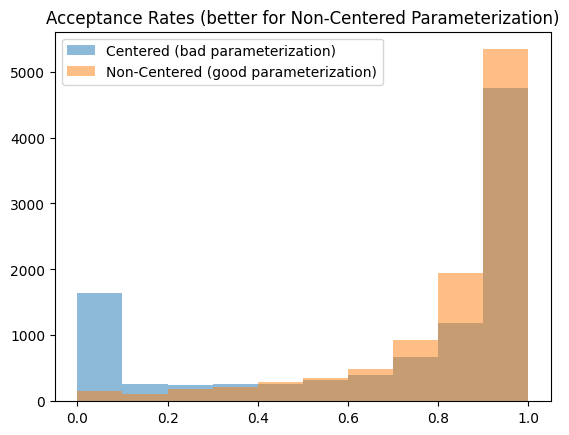

In [ ]:

import matplotlib.pyplot as plt
plt.hist(fit_C.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,
         label='Centered (bad parameterization)');
plt.hist(fit_NC.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,
         label='Non-Centered (good parameterization)');
plt.title('Acceptance Rates (better for Non-Centered Parameterization)'); plt.legend();

We can see that the acceptance rate for the non-centred  model is much closer to 1 while the centred model is very close to 0. Implying that our samples get "stuck" more with the centered model.

The starter code only uses 2 chains so PYMC shows a warning saying that for a more accurate computation of convergence at least 4 chain should be used.

In the centered model, the treatment effects are directly sampled from a common distribution with a fixed scale. This model directly models the treatment effects in each school and their variability. However, because the parameters are directly sampled, it can result in regions of high curvature in the energy landscape, which can lead to inefficiencies in the sampling process, especially for hierarchical models with many parameters. This approach can be intuitive, but it can lead to issues when there are strong differences between individual observations and the overall average. It can result in regions of high curvature in the parameter space, making it harder for the sampling algorithm to explore efficiently.

In the uncentered model, auxiliary variables are introduced to decouple the original parameters, redistributing the curvature in the energy landscape. Specifically, theta being independant of tau. So this could still result in energy having a high curvature wrt to tau, but with this decoupling this cannot happen wrt to theta as well. This redistribution makes the energy landscape more favourable for sampling, leading to more efficient exploration of the parameter space. By decoupling the parameters, the uncentered model can improve convergence and mixing of the Markov chains, especially in complex hierarchical models.

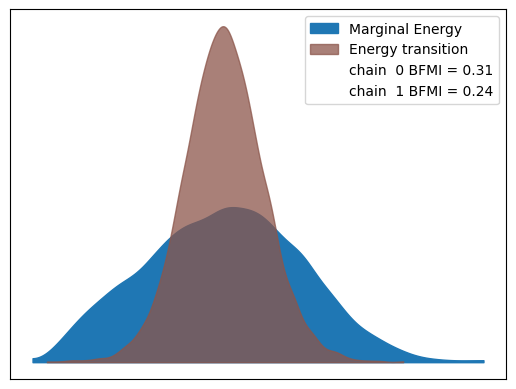

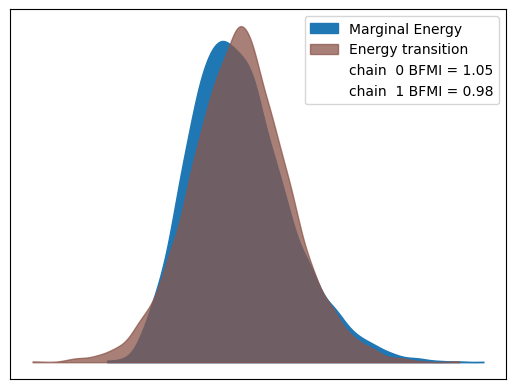

In [ ]:
import arviz as az
az.plot_energy(fit_C);
az.plot_energy(fit_NC);

We can see that for the centered model that the distruibution is much more narrow. Showing that we did not properly explore the parameter space.

In the uncentered model the distributions are much closer to each other and it explores more of the parameter space compared to the centered model.